In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import noisereduce as nr
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
import IPython
import os

C:\Users\parth\anaconda3\envs\dcase2019\lib\site-packages\noisereduce\noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Using TensorFlow backend.


In [2]:
#Load segment audio classification model

model_path = r"Audio_classification/Models/"
model_name = "audio_NN_New2020_03_23_16_40_28_acc_90.37"

# Model reconstruction from JSON file
with open(model_path + model_name + '.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(model_path + model_name + '.h5')

# Replicate label encoder
lb = LabelEncoder()
lb.fit_transform(['Calling', 'Clapping', 'Falling', 'Sweeping', 'WashingHand', 'WatchingTV','enteringExiting','other'])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [85]:
#Some Utils

# Plot audio with zoomed in y axis
def plotAudio(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    ax.margins(2, -0.1)
    plt.show()

# Plot audio
def plotAudio2(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    plt.show()

# Split a given long audio file on silent parts.
# Accepts audio numpy array audio_data, window length w and hop length h, threshold_level, tolerence
# threshold_level: Silence threshold
# Higher tolence to prevent small silence parts from splitting the audio.
# Returns array containing arrays of [start, end] points of resulting audio clips
def split_audio(audio_data, w, h, threshold_level, tolerence=10):
    split_map = []
    start = 0
    data = np.abs(audio_data)
    threshold = threshold_level*np.mean(data[:20000])
    inside_sound = False
    near = 0
    for i in range(0,len(data)-w, h):
        win_mean = np.mean(data[i:i+w])
        if(win_mean>threshold and not(inside_sound)):
#             print(i, 'inside sound')
            inside_sound = True
            start = i
        if(win_mean<=threshold and inside_sound and near>tolerence):
#             print(i, 'outside sound')
            inside_sound = False
            near = 0
            split_map.append([start, i])
        if(inside_sound and win_mean<=threshold):
            near += 1
    return split_map

def minMaxNormalize(arr):
    mn = np.min(arr)
    mx = np.max(arr)
    return (arr-mn)/(mx-mn)

def predictSound(X):
    stfts = np.abs(librosa.stft(X, n_fft=512, hop_length=256, win_length=512))
    stfts = np.mean(stfts,axis=1)
    stfts = minMaxNormalize(stfts)
    result = model.predict(np.array([stfts]))
    predictions = [np.argmax(y) for y in result]
    return lb.inverse_transform([predictions[0]])[0]

In [78]:
def get_win_mean(audio_data, w, h, threshold_level):
    data = np.abs(audio_data)
    win_mean = np.zeros(shape = raw_audio.shape, dtype = raw_audio.dtype)
    threshold = threshold_level*np.mean(data[:20000])
    print('np.mean(data[:20000]) = ', np.mean(data[:20000]))
    print('threshold = ', threshold)
    for i in range(0,len(data)-w, h):
        win_mean[i] = np.mean(data[i:i+w])
    return win_mean

In [96]:
# place concatenating audio files in a folder

folder = r"sound_clips/"
raw_audio, sr = librosa.load(folder + os.listdir(folder)[0])

cnt = 0
for file in os.listdir(folder):
    cnt += 1
    print(cnt, file)
    if cnt == 1:
        continue
    data, rate = librosa.load(folder + file)
    raw_audio = np.concatenate((raw_audio,data))

1 2019-05-23-15-12-39-670000__1.wav


In [97]:
noisy_part = raw_audio[0:25000]  # Empherically selected noisy_part position for every sample
nr_audio = nr.reduce_noise(audio_clip=raw_audio, noise_clip=noisy_part, verbose=False)

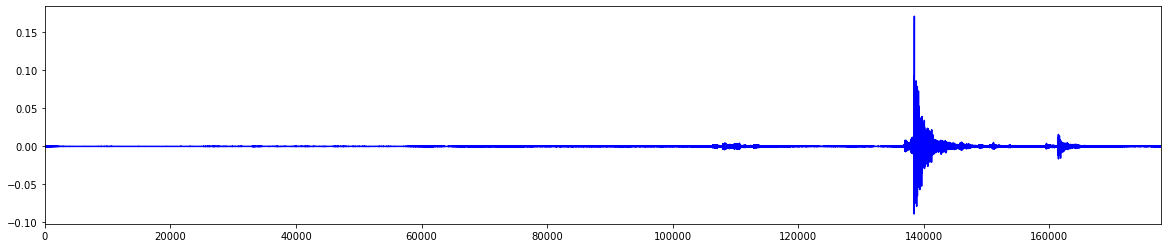

In [98]:
plotAudio2(nr_audio)
IPython.display.display(IPython.display.Audio(data=nr_audio, rate=sr))

np.mean(data[:20000]) =  2.636999e-05
threshold =  0.00039554984141432215


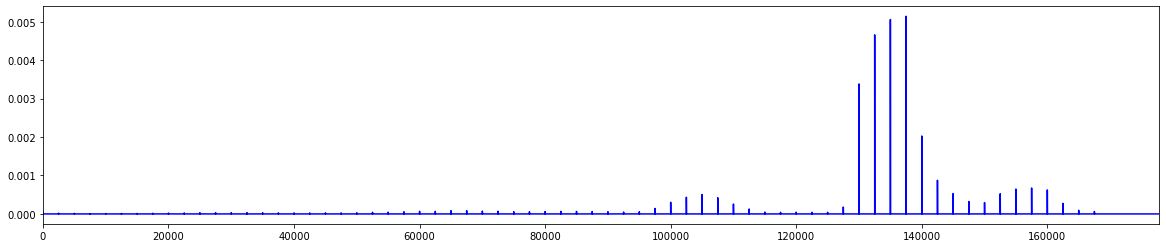

In [99]:
# Only for analysis purpose
plotAudio2(get_win_mean(nr_audio, 10000, 2500, 15))

In [100]:
# Only for analysis purpose
sound_clips = split_audio(nr_audio, 10000, 2500, 15)
print(sound_clips)

[[102500, 165000]]


other


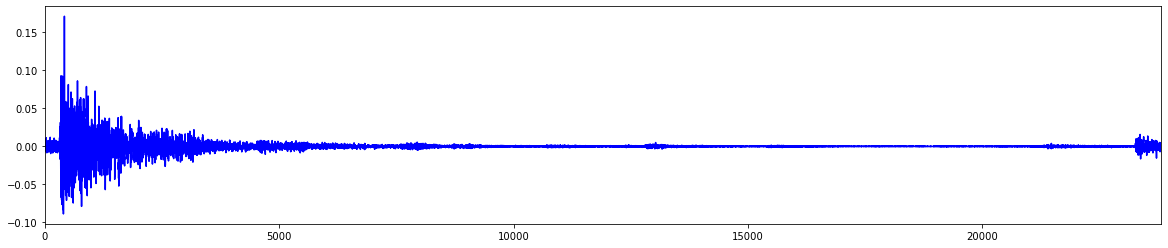

In [101]:
for intvl in sound_clips:
    clip, index = librosa.effects.trim(nr_audio[intvl[0]:intvl[1]], top_db=20, frame_length=512, hop_length=64) # Empherically select top_db for every sample
    print(predictSound(clip))
    plotAudio2(clip)
    IPython.display.display(IPython.display.Audio(data=clip, rate=sr))

In [108]:
# delete
for intvl in sound_clips:
    X, index = librosa.effects.trim(nr_audio[intvl[0]:intvl[1]], top_db=20, frame_length=512, hop_length=64) # Empherically select top_db for every sample
    stfts = np.abs(librosa.stft(X, n_fft=512, hop_length=256, win_length=512))
    stfts = np.mean(stfts,axis=1)
    stfts = minMaxNormalize(stfts)
    result = model.predict(np.array([stfts]))
    print(result)
    predictions = [np.argmax(y) for y in result]
    print(lb.inverse_transform([predictions[0]])[0])
    print(lb.transform(['other'])[0])

[[3.2776890e-09 8.7969808e-04 1.8443245e-05 2.0434932e-11 2.1076577e-14
  9.9120354e-13 1.5346767e-15 9.9910188e-01]]
other
7
